In [1]:
import sys
sys.path.insert(0, '../../')
import ccal
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

import numpy as np
import pandas as pd

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, fcluster, cophenet
from scipy.spatial.distance import pdist
from scipy.spatial import Delaunay, ConvexHull
from sklearn import manifold
from statsmodels.nonparametric.kernel_density import KDEMultivariate
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import numpy as np
import rpy2.robjects as ro
from rpy2.robjects.numpy2ri import numpy2ri
ro.conversion.py2ri = numpy2ri
from rpy2.robjects.packages import importr
mass = importr('MASS')

==================== Computational Cancer Analysis Library ====================
<09:58:31> Checking dependencies ...
<09:58:31> Using the following packages:
<09:58:31> 	matplotlib (v1.5.1)
<09:58:31> 	numpy (v1.10.4)
<09:58:31> 	pandas (v0.18.0)
<09:58:31> 	rpy2 (v2.7.9)
<09:58:31> 	scikit-learn (v0.17.1)
<09:58:31> 	scipy (v0.17.0)
<09:58:31> 	seaborn (v0.7.0)


# get_states

In [2]:
h = ccal.support.read_gct('../../../hematopoietic_cancer/result/ccle_hema/k9/ccle_hema_k_9_H.gct')

ks = [12]

nclustering = 5

print_log = ccal.support.print_log

In [3]:
# Standardize H
standardized_h = ccal.support.standardize_pandas_object(h)

# Clip values less than -3 and more than 3
standardized_clipped_h = standardized_h.clip(-3, 3)

# Get association between samples
sample_associations = ccal.analyze.compare_matrices(standardized_clipped_h, standardized_clipped_h, axis=1)

# Samples' hierarchical cluster assignment per k (k x sample)
labels = pd.DataFrame(index=ks, columns=list(sample_associations.index) + ['cophenetic_correlation'])
for k in ks:
    print_log('Hierarchical clustering with k = {} ...'.format(k))
    
    # Hierarchical cluster the association between the samples and get labels cut-off at k (nclustering x sample)
    nclustering_labels = pd.DataFrame(index=range(nclustering), columns=sample_associations.index)
    for i in range(nclustering):
        print_log('\tClustering #{} ...'.format(i))
        ward = AgglomerativeClustering(n_clusters=k)
        ward.fit(sample_associations)
        nclustering_labels.iloc[i, :] = ward.labels_

    # Get the number of times samples co-cluster (sample x sample)
    ncoclusterings = pd.DataFrame(index=nclustering_labels.columns, columns=nclustering_labels.columns)
    ncoclusterings.fillna(0, inplace=True)
    for i, s in nclustering_labels.iterrows():
        print_log('\tCounting co-clustering at clustering #{} ...'.format(i))
        for i in s.index:
            for j in s.index:
                if i is j or s.ix[i] == s.ix[j]:
                    ncoclusterings.ix[i, j] += 1
    
    # Normalize
    ncoclusterings /= nclustering

    # Convert association to distance
    distances = 1 - ncoclusterings
    
    # Get the final cluster label cut-off at k
    ward = linkage(distances, method='ward')
    labels_ = fcluster(ward, k, criterion='maxclust')
    labels.ix[k, sample_associations.index] = labels_
    
    # Compute the cophenetic correlation (the correlation between cophenetic and Euclidian distances)
    labels.ix[k, 'cophenetic_correlation'] = cophenet(ward, pdist(distances))[0]

<09:58:39> Comparing A3KAW_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (1/166) vs. ...
<09:58:40> Comparing A4FUK_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (2/166) vs. ...
<09:58:40> Comparing ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (3/166) vs. ...
<09:58:41> Comparing AML193_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (4/166) vs. ...
<09:58:41> Comparing AMO1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (5/166) vs. ...
<09:58:42> Comparing BCP1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (6/166) vs. ...
<09:58:42> Comparing BDCM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (7/166) vs. ...
<09:58:42> Comparing BL41_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (8/166) vs. ...
<09:58:43> Comparing BL70_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (9/166) vs. ...
<09:58:43> Comparing BV173_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (10/166) vs. ...
<09:58:44> Comparing CA46_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (11/166) vs. ...
<09:58:44> Comparing CI1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (12/166) vs. ...
<09:58:45> Comparing CMK_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (13/166

# map_onco_gps

In [44]:
h = ccal.support.read_gct('../../../hematopoietic_cancer/result/ccle_hema/k9/ccle_hema_k_9_H.gct')
labels = labels
states = 12
sample_stretch = 2
ngrid = 100

CMAP_CATEGORICAL = ccal.visualize.CMAP_CATEGORICAL

In [19]:
# Standardize H
standardized_h = ccal.support.standardize_pandas_object(h)

# Clip values less than -3 and more than 3
standardized_clipped_h = standardized_h.clip(-3, 3)

# Project the H's components from nsampleD to 2D, getting the x & y coordinates
mds = manifold.MDS()
components_coordinates = mds.fit_transform(standardized_clipped_h)

# Delaunay triangulate the components' 2D projected coordinates
delaunay = Delaunay(components_coordinates)

# Compute convexhull for the components' 2D projected coordinates
convexhull = ConvexHull(components_coordinates)
convexhull_region = mpl.path.Path(convexhull.points[convexhull.vertices])

# Sample, their state labels and x & y coordinates computed using Delaunay triangulation simplices
samples = pd.DataFrame(index=h.columns, columns=['state', 'x', 'y'])

# Get sample labels
samples.ix[:, 'state'] = labels.ix[states, :]

# Get sample x & y coordinates using Delaunay triangulation simplices
for sample in samples.index:
    col = h.ix[:, sample]
    third = col.sort_values()[-3]
    col = col.mask(col < third, other=0)
    
    # TODO: remove assertion
    assert sum(col != 0) == 3
    
    x = sum(col**sample_stretch * components_coordinates[:, 0]) / sum(col**sample_stretch)
    y = sum(col**sample_stretch * components_coordinates[:, 1]) / sum(col**sample_stretch)
    samples.ix[sample, ['x', 'y']] = x, y

# Set x & y coordinate boundaries
xcoordinates = np.concatenate((components_coordinates[:, 0], np.array(samples.ix[:, 'x'])))
xmin = min(xcoordinates)
xmax = max(xcoordinates)
xmargin = (xmax - xmin) / 24
xmin -= xmargin
xmax += xmargin
ycoordinates = np.concatenate((components_coordinates[:, 1], np.array(samples.ix[:, 'y'])))
ymin = min(ycoordinates)
ymax = max(ycoordinates)
ymargin = (ymax - ymin) / 24
ymin -= ymargin
ymax += ymargin

# Set grids
grids = np.linspace(min(xmin, ymin), max(xmax, ymax), num=ngrid)

In [41]:
# Get KDE at each grid intersection for each state
kdes = np.zeros((states + 1, ngrid, ngrid))
bandwidth_x = mass.bcv(np.asarray(samples.ix[:, 'x'].tolist()))[0]
bandwidth_y = mass.bcv(np.asarray(samples.ix[:, 'y'].tolist()))[0]
for s in sorted(samples.ix[:, 'state'].unique()):
    state_coordiantes = samples.ix[samples.ix[:, 'state'] == s, ['x', 'y']]
    x = np.array(state_coordiantes.ix[:, 'x'], dtype=float)
    y = np.array(state_coordiantes.ix[:, 'y'], dtype=float)
    kde = mass.kde2d(x, y, np.asarray([bandwidth_x, bandwidth_y]), n=np.asarray([ngrid]), lims=np.asarray([xmin, xmax, ymin, ymax]))
    kdes[s] = np.asarray(kde[2])

# Assign the best KDE probability and state for each grid intersection
grid_probabilities = np.empty((ngrid, ngrid))
grid_states = np.empty((ngrid, ngrid))
for i in range(ngrid):
    for j in range(ngrid):
        grid_probabilities[i, j] = max(kdes[:, i, j])
        grid_states[i, j] = np.argmax(kdes[:, i, j])

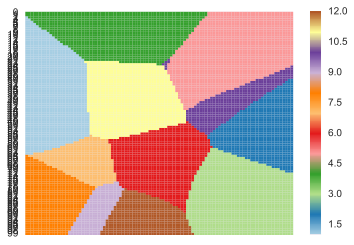

In [45]:
sns.heatmap(grid_states, cmap=CMAP_CATEGORICAL, xticklabels=False)

## plot

In [53]:
figure_size = (10, 10)

delaunay_linewidth = 1
delaunay_linecolor = '#000000'

component_markersize = 15
component_markerfacecolor = '#0059b3'
component_markeredgewidth = delaunay_linewidth
component_markeredgecolor = '#ffffff' #'#9017E6'
component_text_verticalshift = 1
component_fontsize = 16

sample_markersize = 12
sample_markeredgewidth = 0.81
sample_markeredgecolor = '#000000'

contour_n = 15
contour_linewidth = 0.81
contour_linecolor = '#5a5a5a'
contour_alpha = 0.81

background_max_alpha = 1
background_markersize = 5.59

filename = '/Users/Kwat/Desktop/onco_gps'

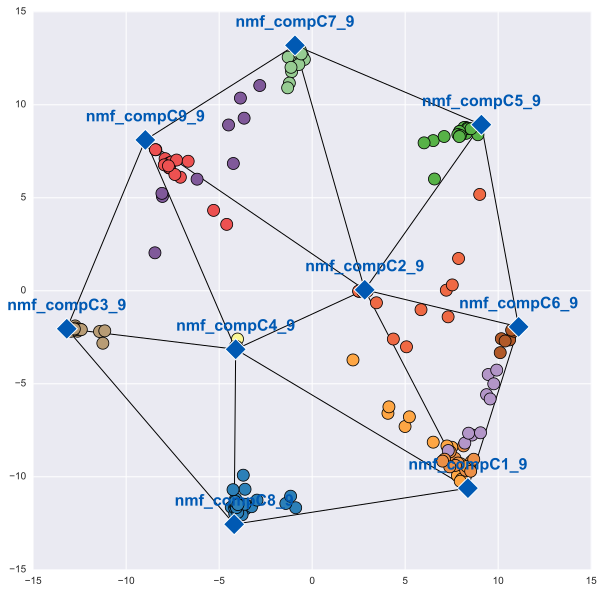

In [55]:
fig, ax = plt.subplots(figsize=figure_size)
ax.axis('on')

# Plot Delaunay triangulation
ax.triplot(delaunay.points[:, 0], delaunay.points[:, 1], delaunay.simplices.copy(),
           linewidth=delaunay_linewidth, color=delaunay_linecolor, zorder=4)

# Plot components
ax.plot(components_coordinates[:, 0], components_coordinates[:, 1], linestyle='', marker='D',
        markersize=component_markersize, markerfacecolor=component_markerfacecolor,
        markeredgewidth=component_markeredgewidth, markeredgecolor=component_markeredgecolor, zorder=6)

# Plot component name
for i in range(components_coordinates.shape[0]):
    ax.text(components_coordinates[i, 0], components_coordinates[i, 1] + component_text_verticalshift, standardized_clipped_h.index[i], fontsize=component_fontsize, weight='bold', color=component_markerfacecolor, horizontalalignment='center', zorder=6)

# Plot samples
for idx, s in samples.iterrows():
    ax.plot(s.ix['x'], s.ix['y'], marker='o', markersize=sample_markersize, markerfacecolor=CMAP_CATEGORICAL(int(s.ix['state'] / states * 255)),
            markeredgewidth=sample_markeredgewidth, markeredgecolor=sample_markeredgecolor, zorder=5)

# Plot contour
# masked_coordinates = []
# for i in range(ngrid):
#     for j in range(ngrid):
#         if not convexhull_region.contains_point((grids[i], grids[j])):
#             masked_coordinates.append([i, j])
# masked_coordinates = np.array(masked_coordinates)
# z = grid_probabilities.copy()
# z[masked_coordinates[:, 0], masked_coordinates[:, 1]] = np.nan
# ax.contour(grids, grids, z, contour_n,
#            linewidths=contour_linewidth, colors=contour_linecolor, alpha=contour_alpha, zorder=2)
ax.contour(grids, grids, grid_probabilities, contour_n,
           linewidths=contour_linewidth, colors=contour_linecolor, alpha=contour_alpha, zorder=2)

# # Plot background
# for i in range(ngrid):
#     for j in range(ngrid):
#         if convexhull_region.contains_point((grids[i], grids[j])):
#              # Normalize color
#             background_color = CMAP_CATEGORICAL(int(grid_states[i, j] / states * 255))

#             # Background color is less saturated than the sample color
#             background_alpha = min(background_max_alpha, (grid_probabilities[i, j] - grid_probabilities.min()) / (grid_probabilities.max() - grid_probabilities.min()) * 0.5)

#             ax.plot(grids[i], grids[j], marker='s', markersize=background_markersize, markerfacecolor=background_color, alpha=background_alpha, zorder=1)
#         else:
#             ax.plot(grids[i], grids[j], marker='s', markersize=background_markersize * 1.2, markerfacecolor='w', zorder=3)

# fig.savefig(filename)